In [1]:
# import statements
import tensorflow as tf
import os
import time
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split


from keras.utils.layer_utils import count_params

In [2]:
# mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# map disease code to disease name
label_map = {"0": "Cassava Bacterial Blight (CBB)", 
          "1": "Cassava Brown Streak Disease (CBSD)", 
          "2": "Cassava Green Mottle (CGM)", 
          "3": "Cassava Mosaic Disease (CMD)", 
          "4": "Healthy"}

In [4]:
# load in labels from csv
data = pd.read_csv('/content/gdrive/MyDrive/ENDG511-Project/train.csv') 
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
# count the number of different labels in the dataset
data['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

*train.csv* is a csv file that includes 2 columns:

*   *image_id* : name of image in dataset
*   *label* : disease code that maps to a disease name

Disease code 3 (Cassava Mosaic Disease) dominates over the other classes. There are similar amounts of data samples for disease codes 4, 2, and 1 (Healthy, Cassava Green Mottle, and Cassava Brown Streak Disease respectively) and few data samples for disease code 0 (Cassava Bacterial Blight).

Due to the unequal representation of each class, the machine learning model may be biased towards disease code 3 in its prediction.



In [6]:
# extract files from cassava-leaf-disease-classification.zip
from zipfile import ZipFile
file_name = '/content/gdrive/MyDrive/ENDG511-Project/cassava-leaf-disease-classification.zip' # TODO: navigate to this file in your directory

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


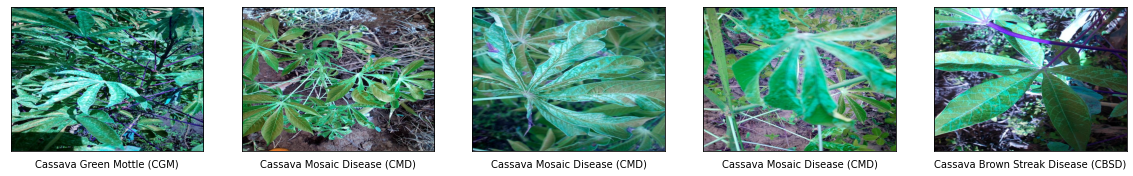

In [7]:
# check training images
plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots(1,5)
n=0
for col in ax:
  n=n+100
  img = cv2.imread('/content/train_images/'+data['image_id'][n], cv2.IMREAD_UNCHANGED)
  col.imshow(img)
  col.set_xticks([])
  col.set_yticks([])
  col.set_xlabel(label_map.get(str(data['label'][n])))
plt.show()


In [8]:
# check for missing values
data.isna().sum()

image_id    0
label       0
dtype: int64

No values are missing, so no additional data cleaning is required.

In [9]:
# convert labels to strings for Image Data Generator
data.label = data.label.astype(str)

# split data into training and testing sets - use 80/20 ratio
train_images, test_images = train_test_split(data, test_size=0.2, stratify=data['label'])

In [10]:
# initialize the Image Data Generator class - data augmentation
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.0,
                                                            rotation_range=20,
                                                            zoom_range=0.05,
                                                            width_shift_range=0.05,
                                                            height_shift_range=0.05,
                                                            shear_range=0.05,
                                                            horizontal_flip=True)

# initialize training generator
IG_train = ImageFlow.flow_from_dataframe(train_images,directory='/content/train_images/',x_col='image_id',
                                         y_col='label',batch_size=100,seed=30,target_size=(128,128))

# initialize testing generator
IG_test = ImageFlow.flow_from_dataframe(test_images,directory='/content/train_images/',x_col='image_id',
                                        y_col='label',batch_size=100,seed=30,target_size=(128,128))


Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


** I see you already did the preprocessing (data augmentation) above, so I'm going to skip over that and head straight to loading MobileNetV2 and training a few models

** I had to change the target shape to (128,128) for the images to work with MobileNetV2

** Ran into a lot of problems with MobileNetV2. It is not a sequential model (each layer is not necessarily connected to the next - there are many intricate connections that skip over some layers or loop back in some cases!) and therefore the transfer learning pipeline described in class cannot be used. As a result, I had to opt for MobileNet (V1).

Next, we will import MobileNet with weights pre-trained on the ImageNet dataset. The final fully-connected layer will not be transferred (include_top=False) since the classification problem in this project has a different number of classes than the data in ImageNet.

Since it is easier to manage the Keras Sequential Model class (as opposed to Functional Model class), we will also move these weights over to said model type.

In [11]:
load_model = tf.keras.applications.MobileNet(
                  input_shape=IG_train.image_shape,
                  alpha=1.0,
                  include_top=False,
                  weights='imagenet',
                  input_tensor=None,
                  pooling='max',
                  classifier_activation='softmax'
              )

#Convert from functional to sequential model
base_model = tf.keras.models.Sequential()
for layer in load_model.layers:
  base_model.add(layer)

#Need to add an output (dense) layer with random weights since include_top=False
base_model.add(tf.keras.layers.Dense(5, activation='softmax'))

base_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                          
                                                         

Now, we create a model with the same architecture as MobileNetV2, but initialized with random weights instead.

In [12]:
load_model = tf.keras.applications.MobileNet(
                  input_shape=IG_train.image_shape,
                  alpha=1.0,
                  include_top=True,
                  weights=None,
                  input_tensor=None,
                  pooling='max',
                  classes=5,
                  classifier_activation='softmax'
              )

random_model = tf.keras.models.Sequential()
for layer in load_model.layers:
  random_model.add(layer)

random_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 64, 64, 32)       

The transfer_model() function defined below is responsible for transferring a varying number of layers from the pre-trained MobileNetV2.

In [13]:
def transfer_model(layerNum_list, base_model,random_model,batch_size=254,IG_train=None,IG_test=None,Trainable=False):
  
  #Empty dictionaries for saving each model's accuracies. 
  history={}
  y_pred={}
  time_={}
  evaluation={}
 

  # The core logic of AnB architecture 
  # Create a model in each out loop and evaluate it 
  for i in range(len(layerNum_list)):

    #Create a new sequential model
    model_new = models.Sequential()

    #Create the base_model layers that are trainsferred
    base_model_layers = []
    for n in range(layerNum_list[i]-1,-len(base_model.layers)-1,-1):
      
      #Define whether transferred base layers are trainable or not
      base_model.layers[n].trainable = Trainable

      base_model_layers.append(base_model.get_layer(index = n))
    base_model_layers.reverse()

    #Create the model layers that are randomly initialized
    random_model_layers = []
    for n in range(-1,layerNum_list[i]-1,-1):
      random_model_layers.append(random_model.get_layer(index = n))
    random_model_layers.reverse()
    
    #Create the new model
    for layer in base_model_layers:
      model_new.add(layer)
    for layer in random_model_layers:
      model_new.add(layer)

    #defining callbacks
    #Call back 1: 
    base_learning_rate = 0.001
    ES=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    #call back 2: 
    RLR= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

    #compiling each model
    model_new.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    #training each model.
    # saving the iteration's output (accuracies) to use it at a later stage

    print('\n MODEL',i+1, 'TRAINING STARTED ... ')
    start_time = time.time()
    history[i] = model_new.fit(IG_train,batch_size=batch_size, epochs=1,validation_data=IG_test,callbacks=[ES,RLR])
    time_[i] = time.time() - start_time

    #check trainable parameters
    trainable_count = count_params(model_new.trainable_weights)
    non_trainable_count = count_params(model_new.non_trainable_weights)
    print('Trainable Parameters:',trainable_count)
    print('Non-Trainable Parameters:',non_trainable_count,'\n')

    print('\n MODEL',i+1, 'TRAINING ENDED ... ')

    
    y_pred[i]=model_new.predict(IG_test,verbose=0)
    evaluation[i] = model_new.evaluate(IG_test,verbose=0)

  return history,time_,y_pred,evaluation  


The following approach involves splitting the model architecture into 13 sections and transferring certain portions at a time.

In [37]:
layers_list = [int(x) for x in np.linspace(-len(base_model.layers)+1,-9,12)]

First, we will evaluate performance without fine tuning.

In [38]:
history,time_,y_pred,evaluation = transfer_model(layers_list, base_model=base_model,random_model=random_model, batch_size=254, \
                                                               IG_train=IG_train, IG_test=IG_test, Trainable=False)


 MODEL 1 TRAINING STARTED ... 
172/172 [==============================] - 249s 1s/step - loss: 0.9423 - accuracy: 0.6564 - val_loss: 1.1809 - val_accuracy: 0.6329 - lr: 0.0010
Trainable Parameters: 3210885
Non-Trainable Parameters: 22688 


 MODEL 1 TRAINING ENDED ... 

 MODEL 2 TRAINING STARTED ... 
172/172 [==============================] - 248s 1s/step - loss: 0.7881 - accuracy: 0.7031 - val_loss: 1.7695 - val_accuracy: 0.2605 - lr: 0.0010
Trainable Parameters: 3208069
Non-Trainable Parameters: 25344 


 MODEL 2 TRAINING ENDED ... 

 MODEL 3 TRAINING STARTED ... 
172/172 [==============================] - 247s 1s/step - loss: 0.8825 - accuracy: 0.6690 - val_loss: 1.3884 - val_accuracy: 0.4397 - lr: 0.0010
Trainable Parameters: 3198085
Non-Trainable Parameters: 34240 


 MODEL 3 TRAINING ENDED ... 

 MODEL 4 TRAINING STARTED ... 
172/172 [==============================] - 246s 1s/step - loss: 0.7961 - accuracy: 0.7040 - val_loss: 0.8078 - val_accuracy: 0.7056 - lr: 0.0010
Trainable 

In [56]:
lists = [history,time_,y_pred,evaluation]
names = ['history','time_','y_pred','evaluation']
for i in range(4):
  file = open('/content/gdrive/MyDrive/ENDG511-Project/'+names[i]+'.txt','w')
  for key,value in lists[i].items():
    file.write(str(value)+"\n")
  file.close()


Next, we will allow fine tuning and evaluate performance.

In [39]:
history_plus,time_plus,y_pred_plus,evaluation_plus = transfer_model(layers_list, base_model=base_model,random_model=random_model, batch_size=254, \
                                                               IG_train=IG_train, IG_test=IG_test, Trainable=True)


 MODEL 1 TRAINING STARTED ... 


AttributeError: ignored

Finally, we will plot a graph showing the change in accuracy versus the number of transferred layers.

In [95]:
plt.rcParams["figure.figsize"] = (8,5)
accuracies = []
accuracies_plus = []
layers_transferred = [len(base_model.layers)+x for x in layers_list]
for k,v in evaluation.items():
  accuracies.append(v[1])
for k,v in evaluation_plus.items():
  accuracies_plus.append(v[1])


plt.plot(layers_transferred,accuracies,label = 'Transferred Weights Frozen',marker='o')
plt.plot(layers_transferred,accuracies_plus,label = 'Fine Tuning Allowed',marker='o')
plt.xlabel('Number of Layers Transferred')
plt.ylabel('Accuracy (higher is better)')
plt.title('Accuracy vs. Layers Transferred')
plt.xticks(range(0,len(base_model.layers)))
plt.grid()
plt.legend()
plt.show()

In [16]:
layers_list

[-86, -79, -72, -65, -58, -51, -44, -37, -30, -23, -16, -9, -2]

In [ ]:
# function to implement the grad-CAM algorithm

def gradCAM(model, image):
  """Implements Grad-CAM algorithm

  Args:
    model: an instantiated model
    image: 2D image under analysis
  Returns:
    Heatmap generated for input image to class.
  """
  # finds last convolutional layer in model
  for layer in reversed(model.layers):
    if len(layer.output_shape) == 4:
      if 'conv' in layer.name:
        layerName = layer.name
        break
  
  # instantiate newly defined model
  GC_Model = Model(inputs=[model.input], outputs=[model.get_layer(layerName).output, model.output])

  # automatic differentiation (comput a value and compute the derivatives of that value)
  with tf.GradientTape() as tape:
    (convOutputs, predictions) = GC_Model(np.expand_dims(image, axis=0))
    class_ind = np.argmax(predictions)
    loss = predictions[:, class_ind]
  grads = tape.gradient(loss, convOutputs)

  # compute alpha (average of gradient values)
  weights = tf.reduce_mean(grads[0], axis=(0,1))
  
  #perform weighted combination of feature map activations and alpha weights
  cam = tf.reduce_sum(tf.multiply(weights, convOutputs[0]), axis=-1)

  # resize heatmap
  heatmap = cv2.resize(cam.numpy(), (image.shape[0], image.shape[1]))

  # apply ReLu to class discriminative map and normalize values
  # (only interested in features that have a positive effect on the class of interest)
  heatmap = np.maximum (heatmap, 0) / np.max(heatmap)

  # return resulting heatmap
  return heatmap
